In [1]:
import os
import polars as pl


while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())

from notebooks.price_cube.enums import Category, Column
import matplotlib.pyplot as plt
from notebooks.price_cube.environment import Environment
import numpy as np
from notebooks.price_cube.utils import logistic_decay
from scipy.optimize import minimize_scalar


/Users/cristian/Personal/Projects/nlp-playground


In [2]:
BASE_DIR = os.path.join("notebooks", "price_cube")
DATASET_DIR = os.path.join(BASE_DIR, "dataset")
DATA_PATH = os.path.join(DATASET_DIR, "price_cube.parquet")

In [3]:
DATA_PATH

'notebooks/price_cube/dataset/price_cube.parquet'

In [4]:
df = pl.read_parquet(DATA_PATH)

In [6]:
df.group_by([Column.SKU.value]).agg(
    [
        pl.col(Column.PRODUCT_CATEGORY.value)
        .first()
        .alias(Column.PRODUCT_CATEGORY.value),
        pl.col(Column.CURRENT_PRICE.value).mean().alias(Column.CURRENT_PRICE.value),
        pl.col(Column.SUGGESTED_PRICE.value)
        .first()
        .alias(Column.SUGGESTED_PRICE.value),
        pl.col(Column.GLOBAL_OPTIMAL_PRICE.value)
        .first()
        .alias(Column.GLOBAL_OPTIMAL_PRICE.value),
        pl.col(Column.CURRENT_NET_MARGIN.value)
        .sum()
        .alias(Column.CURRENT_NET_MARGIN.value),
        # pl.col(Column.EXPECTED_NET_MARGIN_CURRENT_VOLUME.value)
        # .sum()
        # .alias(Column.EXPECTED_NET_MARGIN_CURRENT_VOLUME.value),
        pl.col(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value)
        .sum()
        .alias(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value),
        pl.col(Column.OPTIMAL_NET_MARGIN.value)
        .sum()
        .alias(Column.OPTIMAL_NET_MARGIN.value),
    ]
)

sku,product_category,current_price,suggested_price,global_optimal_price,current_net_margin,expected_net_margin_expected_volume,optimal_net_margin
str,str,f64,f64,f64,f64,f64,f64
"""HOME001""","""Home & Kitchen""",59.114753,55.664442,55.664442,364275.167853,454557.753833,454557.752191
"""APP001""","""Apparel""",44.517054,39.431629,39.431626,980882.806558,1.3271e6,1.3271e6
"""APP002""","""Apparel""",79.626161,74.448895,74.448896,591217.721907,813365.534495,813365.548649
"""ELEC001""","""Electronics""",100.268262,96.75775,96.75775,524779.640737,764866.782827,764866.781959
"""BEAU002""","""Beauty & Health""",29.634915,25.913359,25.913359,321811.125675,316811.175697,316811.16661
…,…,…,…,…,…,…,…
"""SPORT001""","""Sports & Outdoors""",27.517749,25.501321,25.501321,396410.419729,444384.496048,444384.496186
"""HOME002""","""Home & Kitchen""",90.329782,83.352311,83.352311,816978.89636,995091.965321,995091.959305
"""ELEC003""","""Electronics""",139.984012,131.485999,131.485999,1.4951e6,1.7110e6,1.7110e6


In [8]:
df.select(
    [
        pl.col(Column.SKU.value),
        pl.col(Column.PRODUCT_CATEGORY.value),
        pl.col(Column.UNIT_COST.value),
        pl.col(Column.CURRENT_PRICE.value),
        pl.col(Column.SUGGESTED_PRICE.value),
        pl.col(Column.CURRENT_NET_MARGIN.value),
        pl.col(Column.EXPECTED_NET_MARGIN_CURRENT_VOLUME.value),
        pl.col(Column.EXPECTED_NET_MARGIN_EXPECTED_VOLUME.value),
        pl.col,
    ]
)


TypeError: 'Expr' object is not callable

In [9]:
def margin_volume_objective(price, cost, L, k, p0):
    """Negative of profit function to be minimized."""
    if price <= cost:
        return np.inf  # don't allow pricing below cost
    volume = logistic_decay(np.array([price]), L, k, p0)[0]
    margin = (price - cost) / cost
    return -margin * volume  # negative for maximization


def find_optimal_price(cost, L, k, p0, price_bounds=(0.01, 10.0)):
    """Find the price that maximizes margin-adjusted volume."""
    result = minimize_scalar(
        margin_volume_objective,
        bounds=price_bounds,
        args=(cost, L, k, p0),
        method="bounded",
    )
    return result.x if result.success else None

In [10]:
env = Environment()

In [11]:
df.group_by(pl.col(Column.SKU.value)).agg(
    [
        pl.col(Column.UNIT_COST.value).max().alias("cost"),
    ]
).sort(Column.SKU.value).write_csv("test.csv")


In [12]:
cost = 2.0
L = 100  # max units sold
k = 5
p0 = 3.0

optimal_price = find_optimal_price(cost, L, k, p0)
print(f"Optimal price: ${optimal_price:.2f}")

Optimal price: $2.79


Product ID: APP001
59.4385602071536
122.32
24.51


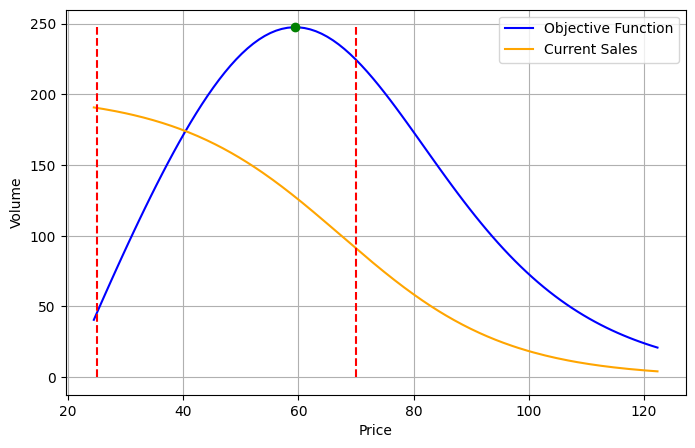

In [13]:
from notebooks.price_cube.constants import (
    MAX_UNITS_SOLD,
    PRODUCT_PRICE_RANGES_CONSTRAINTS,
)


def test(df: pl.DataFrame) -> pl.DataFrame:
    """ """
    volumes = []

    for product_id in df[Column.SKU.value].unique().sort().to_numpy():
        print(f"Product ID: {product_id}")
        products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
            pl.col(Column.CURRENT_PRICE.value)
        )

        # Get the cost of the product
        cost = products[Column.UNIT_COST.value][0]

        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()
        # Set logistic decay parameters based on the data
        L = MAX_UNITS_SOLD[product_id]

        k = np.random.uniform(5, 10) / (
            np.max(current_prices) - np.min(current_prices)
        )  # Dynamic steepness
        p0 = np.median(current_prices)

        # Compute smoothed demand using logistic decay
        smoothed = logistic_decay(current_prices, L=L, k=k, p0=p0)

        noise_strength = 0.07 * L
        smoothed_noisy = smoothed + np.random.normal(
            0, noise_strength, size=smoothed.shape
        )
        smoothed_noisy = np.round(np.clip(smoothed_noisy, 0, None))

        price_bounds = PRODUCT_PRICE_RANGES_CONSTRAINTS[product_id]
        optimal_price = find_optimal_price(cost, L, k, p0, price_bounds=price_bounds)

        x = np.linspace(
            np.min(current_prices),
            np.max(current_prices),
            num=100,
        )
        y = [
            -margin_volume_objective(
                x_i,
                cost,
                L=L,
                k=k,
                p0=p0,
            )
            for x_i in x
        ]

        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()
        units_sold = products[Column.UNITS_SOLD.value].to_numpy()

        print(optimal_price)
        print(current_prices.max())
        print(current_prices.min())

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(x, y, label="Objective Function", color="blue")
        plt.plot(current_prices, smoothed, label="Current Sales", color="orange")

        plt.vlines(
            price_bounds[0],
            ymin=0,
            ymax=max(y),
            color="red",
            linestyle="--",
        )
        plt.vlines(
            price_bounds[1],
            ymin=0,
            ymax=max(y),
            color="red",
            linestyle="--",
        )
        plt.plot(
            optimal_price,
            -margin_volume_objective(
                optimal_price,
                cost,
                L=L,
                k=k,
                p0=p0,
            ),
            marker="o",
            color="green",
        )
        plt.xlabel("Price")
        plt.ylabel("Volume")
        plt.grid(True)
        plt.legend()
        plt.show()

        break


test(df)


Product ID: SPORT003


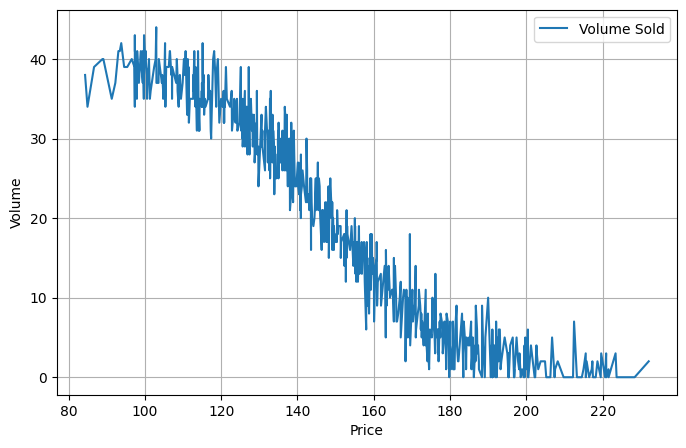

In [30]:
def plot_demand_curve_for_product():
    # Filter product info using Polars
    for product_id in df[Column.SKU.value].unique().to_numpy():
        print(f"Product ID: {product_id}")
        products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
            pl.col(Column.CURRENT_PRICE.value)
        )

        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()
        units_sold = products[Column.UNITS_SOLD.value].to_numpy()

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(current_prices, units_sold, label="Volume Sold")
        plt.xlabel("Price")
        plt.ylabel("Volume")
        plt.grid(True)
        plt.legend()
        plt.show()
        break


plot_demand_curve_for_product()

In [16]:
def fit__curve_for_product():
    # Filter product info using Polars
    for product_id in df[Column.SKU.value].unique().to_numpy():
        print(f"Product ID: {product_id}")
        products = df.filter(pl.col(Column.SKU.value) == product_id).sort(
            pl.col(Column.CURRENT_PRICE.value)
        )

        current_prices = products[Column.CURRENT_PRICE.value].to_numpy()
        units_sold = products[Column.UNITS_SOLD.value].to_numpy()
        obj = env.objective_function(current_prices, units_sold)
        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(current_prices, units_sold, label="Volume Sold")
        plt.xlabel("Price")
        plt.ylabel("Volume")
        plt.grid(True)
        plt.legend()
        plt.show()
        break


plot_demand_curve_for_product()

NameError: name 'plot_demand_curve_for_product' is not defined